<div class="alert alert-info">
<h3>TASK</h3>
<br>
<b>I was assigned to analyze an ongoing A/B test of an online store and give suggestion regarding the test termination time.</b> 
<br>
<br><b>Number of visits from both groups were relatively balance. However, there were small amount of customers appeared in both groups or have extreme order records.</b> <a href="#part_1">[Part_1 Data Overview & Error Check]</a>
</div>

<div class="alert alert-warning">
<h3>APPROACH</h3>
<br>
Mixed group customers were filtered and the two A, B groups were compared with and without the extreme outliers.
<br>
<br><b>Cumulative time series graphs were used to detect different trends in 2 groups metrics and MannWhitneyU tests were applied to check if the differences were statistical significant.</b> <a href="#part_2">[Part_2 Statistic Comparision & Conclusion]</a>
</div>

<div class="alert alert-success">
<h3>RESULT</h3>
<br>
An advantage of real time monitoring of A/B test is that the decision on stopping the A/B test could be made earlier.
<br>
<br>In this case, the experiment reached the stable result and significant level in less than two weeks. 
<br><b>GroupB was determined to be better and the experiment could be stopped.</b>
</div>

# PROJECT: Making Business Decisions for Online Store

### AIM: Prioritize Hypotheses and Analyze A/B Test Result
AIM: Calculate statistical significance of the difference between 2 groups in  
* conversion rate 
* average number of orders per user
* average order size

### TABLE OF CONTENT:
* [PART_1> Data Overview & Error Check](#part_1)
    + Overview
    + Check for balance of group visits
    + Check for mixed group customers
    + Check for extreme outilers data
    
* [PART_2> Statistic Comparision & Conclusion ](#part_2) 
    + With extreme outlier data
    + Without extreme outlier data
   
---

In [1]:
# IMPORT PACKAGES USED FOR PROJECT-------------------------------------------------#

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

pd.set_option('max_colwidth', 400)

# LIST OF DATA FILE USED FOR PROJECT-----------------------------------------------#
path = '/datasets/'
os.chdir(path)

files = {'orders': 'orders_us.csv',
        'visits': 'visits_us.csv'}

# LIST OF FUNCTIONS USED FOR PROJECT-----------------------------------------------#
def Overview_DataFrame (df, title=None):
    print('OVERVIEW DATAFRAME', title)
    print()

    print('Columns informations:')
    print(df.info())
    print()

    print('Data distribution:')
    print(df.describe())
    print()

    print('Dataframe first and last 5 rows:')
    print(df.drop(df.index[5:-5]))
    print('-'*50)


# The function is used in 'Outliner Consideration' part to plot scatter chart with several groups together. The dataframe is in pivot_table format which columns as group names.
def Scatter_Plot_Columns (pivot_df):
    for group in pivot_df.columns:
        plt.scatter(range(0,len(pivot_df)), pivot_df[group],alpha = 0.6,label='group '+group)
    plt.legend()


def Venn3_Diagram(a, b, c, labels=['A', 'B', 'C']):
    from matplotlib_venn import venn3
    a = list(set(a))
    b = list(set(b))
    c = list(set(c))
    
    only_a = len( [x for x in a if x not in b+c] )
    only_b = len( [x for x in b if x not in a+c] )
    only_c = len( [x for x in c if x not in a+b] )

    a_b = len(np.intersect1d(a, b))
    a_c = len(np.intersect1d(a, c))
    b_c = len(np.intersect1d(b, c))
    
    a_b_c = len([ x for x in a if (x in b) and (x in c)])
    
    venn3(subsets=(only_a, only_b, a_b, only_c, a_c, b_c, a_b_c), set_labels=labels)    


# The function is used in 'Cumulative_Test' function to prepare sample for statistic test. The function is used to fill up user orders distribution with 0 value up to the final length as total number of users
def Pad_Truncate_Series(list, target_len, pad_value):
    return pd.Series(list[:target_len] + [pad_value]*(target_len - len(list)))
    

# The function is used in 'Statistic Comparision' part to prepare A/B samples and perform cumulative statistic test for different metrics: 'conversion_rate', 'n_orders_per_user' and 'order_size' 
def Cumulative_Test (order_df, metric, visit_df=None):
    # create list of unique date
    result = pd.DataFrame([], index= sorted(orders['date'].unique()))

    # slice dataframe up to specific date
    for date in result.index:
        order_sliced = order_df[order_df['date']<=date]
        if metric != 'revenue':
            visit_sliced = visit_df[visit_df['date']<=date]

        # prepare samples for MannWhitneyU test
        sample ={}
        for group in ['A','B']:

            if metric == 'revenue':
                sample[group] = order_sliced[order_sliced['group']==group]['revenue']

            elif metric == 'n_orders_per_user':
                sample[group] = order_sliced[order_sliced['group']==group].groupby('visitorId')['transactionId'].nunique()

                sample[group] = Pad_Truncate_Series(
                    sample[group].tolist(),
                    target_len= visit_sliced[visit_sliced['group']==group]['visits'].sum(),
                    pad_value = 0
                )

            elif metric == 'conversion_rate':
                sample[group] = [1]*order_sliced[order_sliced['group']==group]['visitorId'].nunique()

                sample[group] = Pad_Truncate_Series(
                    sample[group],
                    target_len= visit_sliced[visit_sliced['group']==group]['visits'].sum(),
                    pad_value = 0
                )
            
        # MannWhitneyU test
        result.loc[date,'pvalue'] = st.mannwhitneyu(sample['B'], sample['A'], alternative='two-sided')[1]
        result.loc[date,'meanA'] = sample['A'].mean()
        result.loc[date,'meanB'] = sample['B'].mean()
        result.loc[date,'relative_diff'] = sample['B'].mean()/sample['A'].mean()-1

    return result


# The function is used in 'Statistic Comparision' part to graph and print out result of statistic tests as final report
def Project_Statistic_Report (test, alpha=0.05):
    for key in test:        
        print('CUMULATIVE DIFFERENT IN', key.upper(),'BETWEEN GROUPS:')
        print()
        # cumulative data and statistic pvalue graphs
        fig, axes = plt.subplots(ncols=2, figsize=(10,3))

        test[key][['meanA','meanB']].plot.line(title=key, ax=axes[0])
        axes[0].set(xlabel='date', ylabel=key)

        test[key][['pvalue','relative_diff']].plot.line(
            title='Relative different in '+ key+ ' and statistic pvalue',
            color=['black','orange'], ax=axes[1]
        )
        axes[1].axhline(y=alpha, color='black', ls='--', lw=0.7)
        plt.show()
        
        # print out results
        print('LATEST STATISTIC TEST RESULT FOR:')
        
        distributions ={
            'conversion_rate': 'the proportions of users and visitors in both groups',
            'ave_n_orders_per_user': 'the proportions of number of orders for each user in both groups',
            'ave_order_size': 'the average order revenue in both groups' 
        }
        
        print('H0 hypothesis:', distributions[key], 'are the same.')
        print('H1 hypothesis:', distributions[key], 'are different.')
        print()
                
        print(test[key].iloc[-1])
        print()
        
        print('With alpha level', alpha,':')
        if test[key]['pvalue'].iloc[-1] < alpha:
            print('We can reject H0 hypothesis,',distributions[key], 'are different.')
        else:
            print('We can not reject H0 hypothesis,',distributions[key], 'could be the same.')
        print('-'*100)
        print()

# PART_1> DATA OVERVIEW & ERROR CHECK <a id="part_1"></a>

### SUMMARY  
  
There are two datasets:  

**visits** dataset contains number of `visits` from each A/B `group` on specific `date`:  
The number of visits seems to distribute evenly between 2 groups (around 400-700 visits a day).  
Here, it is assumed that most users make not more than 1 visit a day and the total "number of visits" is a closed estimation of the total "number of users".
  
**orders** dataset cotains transaction records (`date`, `transactionId`, `revenue`) of each customer(`visitorID`,`group`):  
There is around 1000 customers in total. 5,6% of which are mixed group customers who have records in both groups.  
Customers with extreme number of order (>=4) are all mixed group customers.  
There are some amount of extreme high revenue records causing a shift of the average `revenue` (~130) to 0.75 quantile of the distribution.

**=> For later analysis, mixed group customers are removed. Statistic comparision will be performed 2 times: with and without the extreme outilers data (above 0.99 quantile).**

---

In [2]:
print('_'*10, 'OPEN LIST OF DATA AND OVERVIEW', '_'*10)
print()

visits = pd.read_csv(files['visits'])
orders = pd.read_csv(files['orders'])

Overview_DataFrame(visits, 'VISITS')
print()

Overview_DataFrame(orders, 'ORDERS')

__________ OPEN LIST OF DATA AND OVERVIEW __________

OVERVIEW DATAFRAME VISITS

Columns informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None

Data distribution:
           visits
count   62.000000
mean   607.290323
std    114.400560
min    361.000000
25%    534.000000
50%    624.500000
75%    710.500000
max    770.000000

Dataframe first and last 5 rows:
          date group  visits
0   2019-08-01     A     719
1   2019-08-02     A     619
2   2019-08-03     A     507
3   2019-08-04     A     717
4   2019-08-05     A     756
57  2019-08-27     B     720
58  2019-08-28     B     654
59  2019-08-29     B     531
60  2019-08-30     B     490
61  2019-08-31     B     718
-------------------------

In [3]:
# Change 'date' columns to datatime datatype
orders['date'] = orders['date'].astype('datetime64[D]')
visits['date'] = visits['date'].astype('datetime64[D]')

In [4]:
# check for duplicate in visits
visits[visits[['date','group']].duplicated(keep=False)]

,date,group,visits


In [5]:
# check for duplicate in orders
orders[orders['transactionId'].duplicated(keep=False)]

,transactionId,visitorId,date,revenue,group


__________ CHECK FOR GROUP BALANCE __________



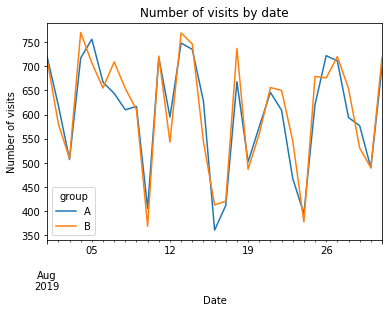

In [6]:
print('_'*10, 'CHECK FOR GROUP BALANCE', '_'*10)
print()
ax = visits.pivot_table(index='date', columns='group', values='visits', aggfunc='sum').plot.line(title='Number of visits by date')
ax.set(xlabel='Date', ylabel='Number of visits')
plt.show()


__________ CHECK FOR MIXED GROUP CUSTOMERS __________



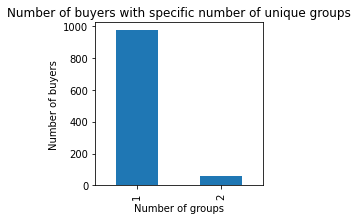

Number of customers: 1031
Number of mixed group customers: 58
Percentage of mixed group customers: 5.625606207565471 %


In [7]:
print('_'*10, 'CHECK FOR MIXED GROUP CUSTOMERS', '_'*10)
print()

# count group for each users
uid_groups = orders.groupby('visitorId')['group'].nunique()

ax=uid_groups.value_counts().plot.bar(title = 'Number of buyers with specific number of unique groups', figsize=(3,3))
ax.set(xlabel='Number of groups', ylabel='Number of buyers')
plt.show()

uid_mixed_group = uid_groups.index[uid_groups>1].tolist()
uid_total = orders['visitorId'].nunique()

print('Number of customers:', uid_total)
print('Number of mixed group customers:', len(uid_mixed_group))
print('Percentage of mixed group customers:', len(uid_mixed_group)/uid_total*100, '%')

__________ CHECK FOR EXTREME NUMBER OF ORDERS PER USER __________



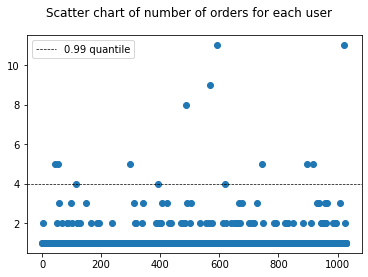

Set extreme number of orders for each user at 0.99 quantile: 4
Number of users with extreme number of orders: 13
Percentage of users with extreme number of orders: 1.2609117361784674 %


In [8]:
extreme_q = 0.99

print('_'*10, 'CHECK FOR EXTREME NUMBER OF ORDERS PER USER', '_'*10)
print()

uid_orders = orders.groupby('visitorId')['transactionId'].nunique()
extreme_order = round(np.quantile(uid_orders, extreme_q))
uid_extreme_orders = uid_orders.index[uid_orders>=extreme_order].tolist()

plt.scatter(range(0,len(uid_orders)), uid_orders)
plt.axhline(y=extreme_order, color='black', ls='--', lw=0.7, label=str(extreme_q)+' quantile')
plt.legend()
plt.suptitle('Scatter chart of number of orders for each user')
plt.show()

print('Set extreme number of orders for each user at 0.99 quantile:', extreme_order)
print('Number of users with extreme number of orders:', len(uid_extreme_orders))
print('Percentage of users with extreme number of orders:', len(uid_extreme_orders)/uid_total*100,'%')

__________ CHECK FOR EXTREME ORDER SIZE __________



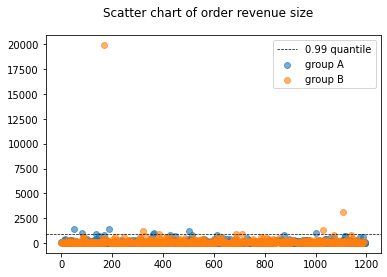

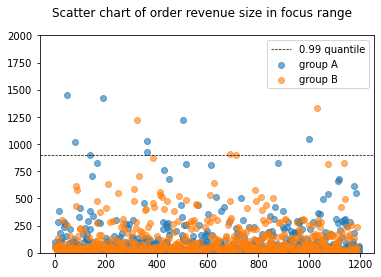

Set extreme extreme order revenue size at 0.99 quantile: 900.9039999999999
Number of users with extreme order revenue size: 11
Percentage of users with extreme order revenue size: 1.066925315227934 %

List of extreme_revenue order:


,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,19920.4,B
662,1811671147,4266935830,2019-08-29,1220.2,A
682,1216533772,4266935830,2019-08-29,1220.2,B
743,3603576309,4133034833,2019-08-09,1050.0,A
744,3668308183,888512513,2019-08-27,1335.6,B
858,192721366,1316129916,2019-08-27,1450.2,A
940,2420050534,4003628586,2019-08-08,905.8,B
949,1347999392,887908475,2019-08-21,930.0,A
1099,316924019,148427295,2019-08-12,1015.9,A
1103,1348774318,1164614297,2019-08-12,1025.8,A


In [9]:
print('_'*10, 'CHECK FOR EXTREME ORDER SIZE', '_'*10)
print()

extreme_revenue = np.quantile(orders['revenue'], extreme_q)
uid_extreme_revenue = orders[orders['revenue']>=extreme_revenue]['visitorId'].unique().tolist()



Scatter_Plot_Columns(orders.pivot_table(index='transactionId', columns='group', values='revenue', aggfunc='sum'))
plt.axhline(y=extreme_revenue, color='black', ls='--', lw=0.7, label=str(extreme_q)+' quantile')
plt.legend()
plt.suptitle('Scatter chart of order revenue size')
plt.show()

Scatter_Plot_Columns(orders.pivot_table(index='transactionId', columns='group', values='revenue', aggfunc='sum'))
plt.ylim(0,2000)
plt.axhline(y=extreme_revenue, color='black', ls='--', lw=0.7, label=str(extreme_q)+' quantile')
plt.legend()
plt.suptitle('Scatter chart of order revenue size in focus range')
plt.show()

print('Set extreme extreme order revenue size at 0.99 quantile:', extreme_revenue)
print('Number of users with extreme order revenue size:', len(uid_extreme_revenue))
print('Percentage of users with extreme order revenue size:', len(uid_extreme_revenue)/uid_total*100,'%')
print()

print('List of extreme_revenue order:')
orders[orders['revenue']>=extreme_revenue]

### COMMENT:

While number of extreme order size are relatively the same in both groups. GroupB have an highly extreme order case (nearly 20000 revenue on 19/August). This rare case could strongly distort the analysis result.

__________ CHECK FOR BIAS IN MIXED GROUP USERS __________



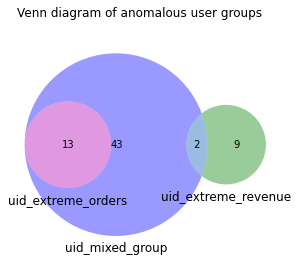


Orders data of mixed group users:


transactionId revenue                     
            nunique  median        mean      sum
group                                           
A                89    45.9  127.448315  11342.9
B                92    68.0  143.363043  13189.4

In [10]:
print('_'*10, 'CHECK FOR BIAS IN MIXED GROUP USERS', '_'*10)
print()

Venn3_Diagram(
    uid_extreme_orders, uid_extreme_revenue, uid_mixed_group,
    labels= ['uid_extreme_orders', 'uid_extreme_revenue', 'uid_mixed_group']
)
plt.suptitle('Venn diagram of anomalous user groups')
plt.show()
print()

print('Orders data of mixed group users:')
orders[orders['visitorId'].isin(uid_mixed_group)].groupby('group').agg(
    {'transactionId':'nunique', 'revenue':['median','mean', 'sum']}
)

### COMMENT:

* All users with extreme number of order (>=4) are mixed group users.


* For mixed group users, `number of orders` and `order size` recorded for groupB are slightly higher than groupA.

# PART_2> STATISTIC COMPARISION & CONCLUSION <a id="part_2"></a>

### SUMMARY

Whether with raw data or filtered data, statistic comparision result between the 2 groups remain the same:

* GroupB have significantly higher `conversion rate` and `average number of orders per user` than groupA (around 15%).  
   
* With extreme outliers, the `average order size` of groupB is around 25% higher than groupA but the different is not statistically significant. Without filtered data, different in `average order size` between 2 groups can no longer be observed after 2 weeks of the experiment.

**=> The experiment reach the stable result and significant level in less than two weeks.
GroupB is determined to be better and the experiment can be stopped.**


__________ STATISTIC COMPARISION WITH EXTREME OUTLIER DATA __________

CUMULATIVE DIFFERENT IN CONVERSION_RATE BETWEEN GROUPS:



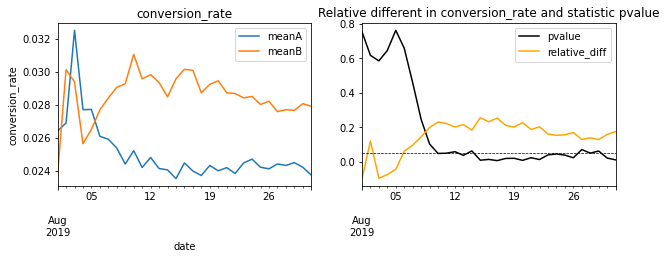

LATEST STATISTIC TEST RESULT FOR:
H0 hypothesis: the proportions of users and visitors in both groups are the same.
H1 hypothesis: the proportions of users and visitors in both groups are different.

pvalue           0.010933
meanA            0.023751
meanB            0.027913
relative_diff    0.175226
Name: 2019-08-31 00:00:00, dtype: float64

With alpha level 0.05 :
We can reject H0 hypothesis, the proportions of users and visitors in both groups are different.
----------------------------------------------------------------------------------------------------

CUMULATIVE DIFFERENT IN AVE_N_ORDERS_PER_USER BETWEEN GROUPS:



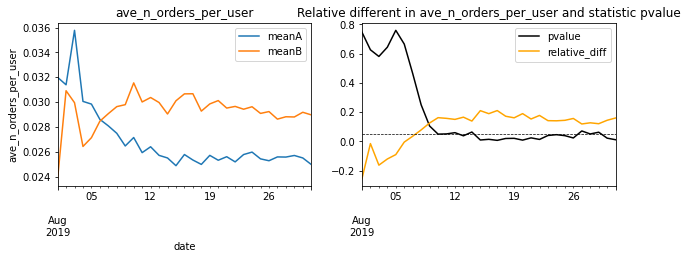

LATEST STATISTIC TEST RESULT FOR:
H0 hypothesis: the proportions of number of orders for each user in both groups are the same.
H1 hypothesis: the proportions of number of orders for each user in both groups are different.

pvalue           0.011018
meanA            0.024979
meanB            0.028970
relative_diff    0.159798
Name: 2019-08-31 00:00:00, dtype: float64

With alpha level 0.05 :
We can reject H0 hypothesis, the proportions of number of orders for each user in both groups are different.
----------------------------------------------------------------------------------------------------

CUMULATIVE DIFFERENT IN AVE_ORDER_SIZE BETWEEN GROUPS:



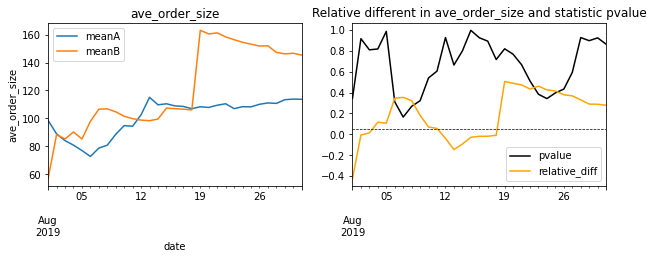

LATEST STATISTIC TEST RESULT FOR:
H0 hypothesis: the average order revenue in both groups are the same.
H1 hypothesis: the average order revenue in both groups are different.

pvalue             0.862233
meanA            113.700855
meanB            145.348905
relative_diff      0.278345
Name: 2019-08-31 00:00:00, dtype: float64

With alpha level 0.05 :
We can not reject H0 hypothesis, the average order revenue in both groups could be the same.
----------------------------------------------------------------------------------------------------



In [11]:
print('_'*10, 'STATISTIC COMPARISION WITH EXTREME OUTLIER DATA', '_'*10)
print()

orders_filtered = orders[~orders['visitorId'].isin(uid_mixed_group)]

test1 = {}
test1['conversion_rate'] = Cumulative_Test (orders_filtered, 'conversion_rate', visits)
test1['ave_n_orders_per_user'] = Cumulative_Test (orders_filtered, 'n_orders_per_user', visits)
test1['ave_order_size'] = Cumulative_Test (orders_filtered, 'revenue')

Project_Statistic_Report(test1, alpha=0.05)

__________ STATISTIC COMPARISION WITHOUT EXTREME OUTLIER DATA __________

CUMULATIVE DIFFERENT IN CONVERSION_RATE BETWEEN GROUPS:



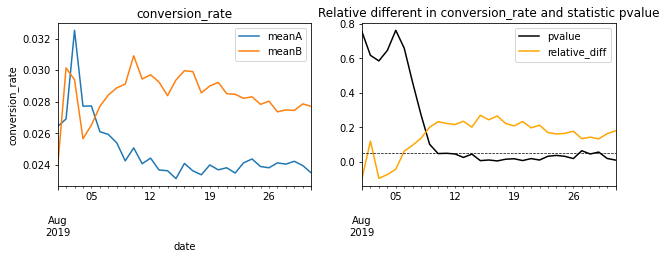

LATEST STATISTIC TEST RESULT FOR:
H0 hypothesis: the proportions of users and visitors in both groups are the same.
H1 hypothesis: the proportions of users and visitors in both groups are different.

pvalue           0.009587
meanA            0.023484
meanB            0.027701
relative_diff    0.179577
Name: 2019-08-31 00:00:00, dtype: float64

With alpha level 0.05 :
We can reject H0 hypothesis, the proportions of users and visitors in both groups are different.
----------------------------------------------------------------------------------------------------

CUMULATIVE DIFFERENT IN AVE_N_ORDERS_PER_USER BETWEEN GROUPS:



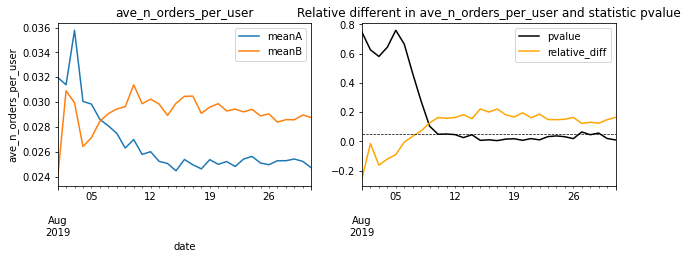

LATEST STATISTIC TEST RESULT FOR:
H0 hypothesis: the proportions of number of orders for each user in both groups are the same.
H1 hypothesis: the proportions of number of orders for each user in both groups are different.

pvalue           0.009663
meanA            0.024712
meanB            0.028759
relative_diff    0.163766
Name: 2019-08-31 00:00:00, dtype: float64

With alpha level 0.05 :
We can reject H0 hypothesis, the proportions of number of orders for each user in both groups are different.
----------------------------------------------------------------------------------------------------

CUMULATIVE DIFFERENT IN AVE_ORDER_SIZE BETWEEN GROUPS:



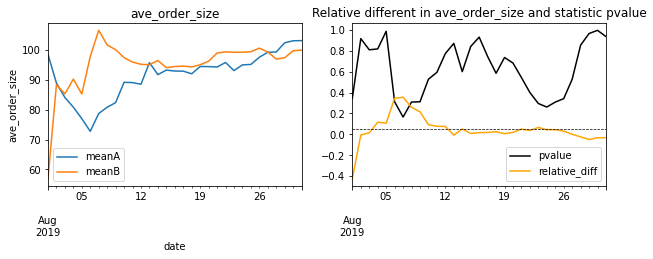

LATEST STATISTIC TEST RESULT FOR:
H0 hypothesis: the average order revenue in both groups are the same.
H1 hypothesis: the average order revenue in both groups are different.

pvalue             0.934329
meanA            103.163067
meanB             99.943566
relative_diff     -0.031208
Name: 2019-08-31 00:00:00, dtype: float64

With alpha level 0.05 :
We can not reject H0 hypothesis, the average order revenue in both groups could be the same.
----------------------------------------------------------------------------------------------------



In [12]:
print('_'*10, 'STATISTIC COMPARISION WITHOUT EXTREME OUTLIER DATA', '_'*10)
print()

orders_filtered = orders[~orders['visitorId'].isin(uid_extreme_revenue + uid_mixed_group)]

test2 = {}
test2['conversion_rate'] = Cumulative_Test (orders_filtered, 'conversion_rate', visits)
test2['ave_n_orders_per_user'] = Cumulative_Test (orders_filtered, 'n_orders_per_user', visits)
test2['ave_order_size'] = Cumulative_Test (orders_filtered, 'revenue')

Project_Statistic_Report(test2, alpha=0.05)